# <center> Machine Learning for Marketing Project: Marketing Campaign

## Project 2 - Classification 
### Predict customers likely to respond to a marketing campaign
### This notebook uses the *campaign.xlsx* dataset. 
#### This notebook includes `'Data Preperation'`, `'Modeling'` for the best model Logistic Regression. `'Business Understanding'`, `'Data Understanding'` and `'Feature Exploration'` parts place in the different notebook. 

### Dataset description

| Feature               | Description                                                    |
|-----------------------|----------------------------------------------------------------|
| AcceptedCmp1          | 1 if customer accepted the offer in the 1st campaign, 0 otherwise |
| AcceptedCmp2          | 1 if customer accepted the offer in the 2nd campaign, 0 otherwise |
| AcceptedCmp3          | 1 if customer accepted the offer in the 3rd campaign, 0 otherwise |
| AcceptedCmp4          | 1 if customer accepted the offer in the 4th campaign, 0 otherwise |
| AcceptedCmp5          | 1 if customer accepted the offer in the 5th campaign, 0 otherwise |
| Response (target)     | 1 if customer accepted the offer in the last campaign, 0 otherwise |
| Complain              | 1 if customer complained in the last 2 years                   |
| DtCustomer            | Date of customer’s enrolment with the company                  |
| Education             | Customer’s level of education                                  |
| Marital               | Customer’s marital status                                      |
| Kidhome               | Number of small children in customer’s household               |
| Teenhome              | Number of teenagers in customer’s household                    |
| Income                | Customer’s yearly household income                             |
| MntFishProducts       | Amount spent on fish products in the last 2 years              |
| MntMeatProducts       | Amount spent on meat products in the last 2 years              |
| MntFruits             | Amount spent on fruits products in the last 2 years            |
| MntSweetProducts      | Amount spent on sweet products in the last 2 years             |
| MntWines              | Amount spent on wine products in the last 2 years              |
| MntGoldProds          | Amount spent on gold products in the last 2 years              |
| NumDealsPurchases     | Number of purchases made with discount                         |
| NumCatalogPurchases   | Number of purchases made using catalogue                       |
| NumStorePurchases     | Number of purchases made directly in stores                    |
| NumWebPurchases       | Number of purchases made through company’s web site            |
| NumWebVisitsMonth     | Number of visits to company’s web site in the last month       |
| Recency               | Number of days since the last purchase                         |

### **Overview**
<p>It is asked to develop a prediction model in such a way that it will be possible for the Marketing Department of a retail company to predict which customers are likely to respond to a marketing campaing based on information from a previous campaign.</p>
<p>A response model can provide a significant boost to the efficiency of a marketing campaign by increasing responses or reducing expenses.</p>

### **What is needed for the model to be considered successfull ?** 
Product manager Sarah striving to optimize the company marketing campaigns. With a keen eye on metrics like recall(>0.75) and F1 score, Sarah ensures their campaigns reach a broad audience (recall) while maintaining precision in targeting (F1 score > 0.5). 

### **Model building**

To achieve the objective, it is followed a systematic approach, CRISP-DM, that involves several stages and proceed to train and evaluate predictive models using 4 different machine learning models with their best parameters such as:

- Decision Tree 
- Random Forest 
- XGBoost
- Logistic Regression

It is tried to explore various models from different families, including bagging techniques like Random Forest, boosting methods such as XGBoost, as well as Logistic Regression which is linear model. Logistic Regression is selected as a best model.

### **Questions or additional informations**
For any additional questions, don't hesitate to get in touch with the instructors. The instructors will also act as the company business/project stakeholder.

In [1]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np
import re
import collections
from datetime import datetime

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

# Data Preprocessing
import imblearn
import sklearn
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import MinMaxScaler
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# Machine Learning Model

from sklearn.linear_model import LogisticRegression
from yellowbrick.model_selection import RFECV

# Model Selection and Evaluation
from sklearn.model_selection import GridSearchCV, train_test_split
from yellowbrick.model_selection import CVScores, LearningCurve
from yellowbrick.classifier import DiscriminationThreshold, ClassPredictionError, PrecisionRecallCurve, ROCAUC
from sklearn import metrics 
import statsmodels.api as sm

# Save the model
import pickle

# Assign random state for reproducebility
random_state=2024

# Set seaborn style
sns.set_style("whitegrid")

# Set the max_columns option to None to display all columns
pd.set_option('display.max_columns', None)

In [2]:
# Print library versions
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)
print("scikit-learn version:", sklearn.__version__) 

pandas version: 2.0.3
numpy version: 1.26.4
matplotlib version: 3.7.2
seaborn version: 0.12.2
scikit-learn version: 1.3.2


##### **Helper functions**

In [3]:
# Code adapted from: Prof. Nuno Antonio, Machine Learning for Marketing
# Plus, figsize parameter is added
# WHY? Visualizing the confusion matrix is a critical step in model evaluation as it provides a detailed, understandable, and actionable insight into the strengths and weaknesses of your model's predictions

# Confusion matrix function
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cf using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    percent:       If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
    title:         Title for the heatmap. Default is None.
    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize is None:
        figsize = plt.rcParams.get('figure.figsize')

    if not xyticks:
        categories = False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    else:
        plt.xlabel('')
    
    if title:
        plt.title(title)
        
    plt.show()

In [4]:
# Code adapted from: Prof. Nuno Antonio, Machine Learning for Marketing
# Plus, added specificity and geometric mean as evaluation metrics
# WHY? This code provides a robust framework for evaluating machine learning models by incorporating a variety of performance metrics. This leads to more informed and reliable assessments, ultimately improving model performance and applicability in real-world scenarios

# Specificity 
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

# Geometric mean
def g_mean(y_true, y_pred):
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return np.sqrt(sensitivity * specificity)

# Performance metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
    measures = {
        'Accuracy': metricsObj.accuracy_score,
        'Precision': metricsObj.precision_score,
        'Recall': metricsObj.recall_score,
        'F1-score': metricsObj.f1_score,
        'Specificity': specificity_score,
        'G-Mean': g_mean
    }

    train_results = [measure_func(yTrain, yPredTrain) if measure_func not in [g_mean, specificity_score] else measure_func(yTrain, yPredTrain) for measure_func in measures.values()]
    test_results = [measure_func(yTest, yPredTest) if measure_func not in [g_mean, specificity_score] else measure_func(yTest, yPredTest) for measure_func in measures.values()]

    resultsDF = pd.DataFrame({'Measure': measures.keys(), 'Train': train_results, 'Test': test_results})
    return resultsDF

### **Load the data**

In [5]:
# Load the excel file
ds = pd.read_excel('campaign.xlsx', engine='openpyxl')

### **Dataset first look**

In [6]:
# Show top 5 rows
print(ds.shape)
print(ds.columns)
print(ds.dtypes)
ds.head()

(2240, 29)
Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')
ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines               float64
MntFruits              float64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds           float64
NumD

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635.0,88.0,546,172,88,88.0,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11.0,1.0,6,2,1,6.0,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426.0,49.0,127,111,21,42.0,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11.0,4.0,20,10,3,5.0,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173.0,43.0,118,46,27,15.0,5,5,3,6,5,0,0,0,0,0,0,3,11,0


### **Reformat the `Dt_Customer` dtype to datetime**

In [7]:
# Reformat
ds['Dt_Customer'] = pd.to_datetime(ds['Dt_Customer'])

# Confirm
print(ds['Dt_Customer'].dtype)

datetime64[ns]


## **3. DATA PREPARATION**

In [8]:
# Create a modeling dataset from the original dataset to prevent data leakage. Apply data cleaning and preprocessing on the copied version
# Since the dataset is small and memory usage is not a concern, deep copy is applied
X = ds.copy(deep=True)
print(X.columns)

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')


In [9]:
# Drop the columns that don't provide meaningfull pattern for prediction
X.drop(['ID', 'Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)

# Confirm
X.columns

Index(['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response'],
      dtype='object')

### **Data errors handling**

- If you remember from the EDA notebook, we had some data errors in `Dt_Customer` ('2042-11-09', '2041-02-25') and `MntSweetProducts` (2342344, 23423444, 234444) columns. These values were not logical based on the data at hand. For `MntSweetProducts` column, errors will replaced with NaN. Afterwards, they will imputed with median value of the column. Since the data is not normally distributed, median is used as a strategy. Errors in `Dt_Customer` will be dropped. 

### **Handling `MntSweetProducts` errors** 

In [10]:
# Check the number of rows before handling data errors
print("Number of rows before data prepatation:",X.shape)

# Filter and select rows containing the error values in the 'MntSweetProducts' column to see clearly
rows_containing_errors = X[X['MntSweetProducts'].isin([2342344, 23423444, 234444])]
rows_containing_errors

Number of rows before data prepatation: (2240, 26)


,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
523,1953,Graduation,Married,70503.0,0,0,2012-09-30,73,1379.0,33.0,216,0,2342344,66.0,1,2,4,9,6,0,1,1,0,0,0,0
563,1970,2n Cycle,Married,62466.0,0,1,2014-01-15,13,129.0,129.0,259,168,234444,83.0,5,6,3,12,4,0,0,0,0,0,0,0
634,1973,Graduation,Single,83917.0,0,0,2013-04-18,12,514.0,22.0,732,42,23423444,79.0,1,6,7,7,3,0,0,0,0,0,0,1


Number of data errors in `MntSweetProducts` is 3. So after replacing with NaN, the count of missing values should be 3 as well. 

In [11]:
error_values = [2342344, 23423444, 234444]
X.MntSweetProducts.replace(error_values, np.nan, inplace=True)

# Confirmation, check the missing values after replacing with NaN
print("Number of missing values after replacing errors with nan:", X.MntSweetProducts.isnull().sum())

Number of missing values after replacing errors with nan: 3


Perfect! We replaced the error values with NaN, now we will impute those 3 values with median value of the `MntSweetProducts`. 

In [12]:
# Print the median value for MntSweetProducts before imputation
print("Median value of MntSweetProducts column before imputation", X.MntSweetProducts.median())
print("Max value of MntSweetProducts column before imputation", X.MntSweetProducts.max())

Median value of MntSweetProducts column before imputation 8.0
Max value of MntSweetProducts column before imputation 263.0


Before the imputation median value of the column is 8 and the max value is 263. After the imputation, median and max values have to be same as well.

In [13]:
# Impute NaN values with median(8) value of the column
# KNN Imputer is tried but it was assigned same values all the time even if number of neighbors were changed. The column values was not proper for KNN Imputation. For this reason, we go with median imputation since the data is not normally distributed. 
imputer = SimpleImputer(strategy='median')
X['MntSweetProducts'] = imputer.fit_transform(X[['MntSweetProducts']])

In [14]:
# Check the median and the max value after imputation
print("Median value of MntSweetProducts after imputation:", X['MntSweetProducts'].median())
print("Max value of MntSweetProducts after imputation:", X['MntSweetProducts'].max())

# Check if the imputated rows has the 8 as a median value
X['MntSweetProducts'].iloc[[523, 563, 634]]

Median value of MntSweetProducts after imputation: 8.0
Max value of MntSweetProducts after imputation: 263.0


523    8.0
563    8.0
634    8.0
Name: MntSweetProducts, dtype: float64

Amazing! We are correctly imputed NaN values to median value 8. Corresponding rows has the median value in the `MntSweetProducts` column. We can move to handle `Dt_Customer` errors.

### **Handling `Dt_Customer` errors**

In [15]:
# Filter and find rows with the error in the 'Dt_Customer' column
rows_to_remove = X[(X['Dt_Customer'] == pd.to_datetime('2042-11-09')) | (X['Dt_Customer'] == pd.to_datetime('2041-02-25'))]
rows_to_remove

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
46,1996,2n Cycle,Married,7500.0,0,0,2042-11-09,24,3.0,18.0,14,15,22.0,50.0,3,3,1,3,9,0,0,0,0,0,0,1
84,1987,Graduation,Divorced,81361.0,0,0,2041-02-25,18,163.0,23.0,424,27,65.0,76.0,1,3,10,13,1,0,0,0,0,0,0,0


As we can see, there are 2 errors in `Dt_Customer`. Maybe those errors were only a typo, for instance, instead of writing 2012 (--> 2042) or 2011 (--> 2041), it's written current dates. Since it is not sure and number of errors less for a concern, they will be dropped.

In [16]:
# Check max date before dropping 
print("Max date before dropping:", X['Dt_Customer'].max())

# Drop the rows containing error values 
X.drop(rows_to_remove.index, inplace=True)

# Check max date after dropping 
print("Max date after dropping:", X['Dt_Customer'].max())

# Check the number of rows after dropping
print(X.shape)

Max date before dropping: 2042-11-09 00:00:00
Max date after dropping: 2014-06-29 00:00:00
(2238, 26)


Number of rows were 2040 in the beginning of data preparation. 2 rows are successfully dropped. It is always good to make sure everything is fine with the data step by step.

##### **Remove extreme outliers**

In [17]:
# Define continuous columns 
continuous_cols =  ['Income',
                    'Recency',
                    'MntWines', 
                    'MntFruits', 
                    'MntMeatProducts', 
                    'MntFishProducts', 
                    'MntSweetProducts',
                    'MntGoldProds', 
                    'NumDealsPurchases', 
                    'NumWebPurchases', 
                    'NumCatalogPurchases', 
                    'NumStorePurchases', 
                    'NumWebVisitsMonth']

# Loop for all the columns in continuous columns
for col in continuous_cols:
    Q1, Q3 = X[col].quantile([0.10, 0.90]) # Quantile range     # Different ranges were tried by considering not losing too much data. Model had the best results with the range 0.10-0.90
    IQR = Q3 - Q1 # Calculate IQR
    lower_fence = Q1 - 1.5 * IQR # Define lower fence
    upper_fence = Q3 + 1.5 * IQR # Define upper fence

    # Store the values under lower fence and above upper fence as outliers
    outliers = X[(X[col] < lower_fence) | (X[col] > upper_fence)].index 

    # Drop outliers
    X.drop(outliers, inplace=True)

# Check how many rows removed
X.shape

(2215, 26)

Before removing the outliers, number of rows were 2238. 23 data points were dropped as outliers between the range (0.10, 0.90). By considering not losing much information, it is tried to reduce the effect of outliers.

### **KNN - Missing value imputation for `Income`, `MntGoldProds`, `MntFruits`, `MntWines` columns**


In [18]:
# Check summary statistics for the columns to be imputed before imputation
X[['Income', 'MntGoldProds', 'MntFruits', 'MntWines']].describe()

,Income,MntGoldProds,MntFruits,MntWines
count,2194.000000,2163.000000,2213.000000,2212.000000
mean,51957.393801,44.275543,26.434704,305.386076
std,21001.469999,51.480054,39.861218,337.446458
min,3502.000000,0.000000,0.000000,0.000000
25%,35422.250000,9.000000,2.000000,24.000000
50%,51371.000000,25.000000,8.000000,176.000000
75%,68487.000000,57.000000,33.000000,505.000000
max,162397.000000,262.000000,199.000000,1493.000000


In [19]:
# Observe rows with missing values in the 'Income' column before imputation
# Row 10, 43, 48, 58 and 71 has the missing value in 'Income' column
missing_income_rows = X[X['Income'].isnull()]
missing_income_rows.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
10,1983,Graduation,Married,NaN,1,0,2013-11-15,11,5.0,5.0,6,0,2.0,1.0,1,1,0,2,7,0,0,0,0,0,0,0
43,1959,PhD,Single,NaN,0,0,2013-11-05,80,81.0,11.0,50,3,2.0,39.0,1,1,3,4,2,0,0,0,0,0,0,0
48,1951,Graduation,Single,NaN,2,1,2014-01-01,96,48.0,5.0,48,6,10.0,7.0,3,2,1,4,6,0,0,0,0,0,0,0
58,1982,Graduation,Single,NaN,1,0,2013-06-17,57,11.0,3.0,22,2,2.0,6.0,2,2,0,3,6,0,0,0,0,0,0,0
71,1973,2n Cycle,Married,NaN,1,0,2012-09-14,25,25.0,3.0,43,17,4.0,17.0,3,3,0,3,8,0,0,0,0,0,0,0


In [20]:
# Observe rows with missing values in the 'MntGoldProds' column before imputation
# Row 613, 614, 615, 616 and 617 has the missing value in 'MntGoldProds' column
missing_gold_rows = X[X['MntGoldProds'].isnull()]
missing_gold_rows.head(5)

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
613,1967,Graduation,Married,22574.0,2,1,2013-10-28,28,25.0,0.0,8,2,0.0,NaN,2,2,0,3,7,0,0,0,0,0,0,0
614,1969,PhD,Single,48240.0,0,0,2012-11-09,73,389.0,91.0,248,64,49.0,NaN,3,6,3,13,5,0,0,0,0,0,0,1
615,1974,Graduation,Married,45837.0,1,1,2013-07-26,88,215.0,13.0,87,17,17.0,NaN,5,6,2,5,7,0,0,0,0,0,0,0
616,1965,Master,Single,35791.0,2,1,2013-05-06,94,27.0,0.0,5,0,0.0,NaN,2,1,0,3,8,0,0,0,0,0,0,0
617,1976,PhD,Together,162397.0,1,1,2013-06-03,31,85.0,1.0,16,2,1.0,NaN,0,0,0,1,1,0,0,0,0,0,0,0


In [21]:
# Observe rows with missing values in the 'MntFruits' column before imputation
# Row 336 and 373 has the missing value in 'MntFruits' column
missing_fruits_rows = X[X['MntFruits'].isnull()]
missing_fruits_rows.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
336,1968,Graduation,Divorced,75693.0,0,0,2012-12-06,10,797.0,NaN,293,72,97.0,30.0,1,11,4,6,4,0,1,1,1,0,0,1
373,1966,Graduation,Single,63810.0,0,1,2012-11-11,45,977.0,NaN,253,16,12.0,101.0,4,4,3,12,8,0,1,0,0,0,0,0


In [22]:
# Observe rows with missing values in the 'MntWines' column before imputation
# Row 150, 190 and 368 has the missing value in 'MntWines' column
missing_wines_rows = X[X['MntWines'].isnull()]
missing_wines_rows.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
150,1953,Master,Married,59354.0,0,2,2014-04-24,59,NaN,21.0,78,39,13.0,13.0,1,4,4,7,3,0,0,0,0,0,0,0
190,1978,Basic,Together,24882.0,1,0,2012-09-09,52,NaN,4.0,10,29,0.0,36.0,1,1,1,2,6,1,0,0,0,0,0,0
368,1962,Graduation,Together,72025.0,0,0,2012-11-17,27,NaN,33.0,549,151,133.0,233.0,1,4,3,8,3,0,0,0,0,0,0,0


### **Impute missing values with KNN**

In [23]:
# Define the columns to impute
columns_to_impute = ['Income', 'MntGoldProds', 'MntFruits', 'MntWines']  

# Initialize the KNN imputer
knn_imputer = KNNImputer(n_neighbors=3)  

# Impute missing values for the selected columns
X[columns_to_impute] = knn_imputer.fit_transform(X[columns_to_impute])

In [24]:
# Check summary statistics after imputation
X[['Income', 'MntGoldProds', 'MntFruits', 'MntWines']].describe()

,Income,MntGoldProds,MntFruits,MntWines
count,2215.000000,2215.000000,2215.000000,2215.000000
mean,51910.670730,43.815500,26.484725,305.429195
std,20962.376601,51.144525,39.884569,337.294162
min,3502.000000,0.000000,0.000000,0.000000
25%,35482.000000,9.000000,2.000000,24.000000
50%,51287.000000,24.000000,8.000000,176.000000
75%,68429.500000,56.000000,33.000000,505.000000
max,162397.000000,262.000000,199.000000,1493.000000


In [25]:
# Check if the imputation values make sense for corresponding rows in 'Income'
X.iloc[[9, 40, 44, 54, 67]]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
10,1983,Graduation,Married,37287.333333,1,0,2013-11-15,11,5.0,5.0,6,0,2.0,1.0,1,1,0,2,7,0,0,0,0,0,0,0
43,1959,PhD,Single,37464.000000,0,0,2013-11-05,80,81.0,11.0,50,3,2.0,39.0,1,1,3,4,2,0,0,0,0,0,0,0
48,1951,Graduation,Single,41730.000000,2,1,2014-01-01,96,48.0,5.0,48,6,10.0,7.0,3,2,1,4,6,0,0,0,0,0,0,0
58,1982,Graduation,Single,22945.666667,1,0,2013-06-17,57,11.0,3.0,22,2,2.0,6.0,2,2,0,3,6,0,0,0,0,0,0,0
71,1973,2n Cycle,Married,41353.333333,1,0,2012-09-14,25,25.0,3.0,43,17,4.0,17.0,3,3,0,3,8,0,0,0,0,0,0,0


In [26]:
# # Check if the imputation values make sense for corresponding rows in 'MntGoldProds'
X.iloc[[604, 605, 606, 607, 608]]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
613,1967,Graduation,Married,22574.0,2,1,2013-10-28,28,25.0,0.0,8,2,0.0,4.000000,2,2,0,3,7,0,0,0,0,0,0,0
614,1969,PhD,Single,48240.0,0,0,2012-11-09,73,389.0,91.0,248,64,49.0,43.000000,3,6,3,13,5,0,0,0,0,0,0,1
615,1974,Graduation,Married,45837.0,1,1,2013-07-26,88,215.0,13.0,87,17,17.0,95.000000,5,6,2,5,7,0,0,0,0,0,0,0
616,1965,Master,Single,35791.0,2,1,2013-05-06,94,27.0,0.0,5,0,0.0,7.666667,2,1,0,3,8,0,0,0,0,0,0,0
617,1976,PhD,Together,162397.0,1,1,2013-06-03,31,85.0,1.0,16,2,1.0,18.333333,0,0,0,1,1,0,0,0,0,0,0,0


In [27]:
# Check if the imputation values make sense for corresponding rows in 'MntWines'
X.iloc[[145, 184, 362]]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
151,1969,Graduation,Married,65747.0,0,1,2014-03-07,96,346.0,17.0,48,23,13.0,13.0,4,8,1,6,6,0,1,0,0,0,0,0
191,1989,PhD,Together,66973.0,0,0,2013-05-17,98,466.0,22.0,432,147,113.0,102.0,1,8,7,12,3,0,0,0,0,0,0,0
370,1984,2n Cycle,Married,35684.0,1,0,2014-04-22,66,10.0,4.0,7,0,6.0,3.0,1,1,0,3,6,0,0,0,0,0,0,0


In [28]:
# Check if the imputation values make sense for corresponding rows in 'MntFruits'
X.iloc[[330, 367]]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
338,1965,Graduation,Together,83003.0,0,0,2013-03-03,18,856.0,61.0,570,40,25.0,122.0,1,7,6,8,3,0,0,1,0,0,0,1
375,1975,Master,Single,46098.0,1,1,2012-08-18,86,57.0,0.0,27,0,0.0,36.0,4,3,2,2,8,0,0,0,0,0,0,0


Summary statistics (compare before and after) indicates that the missing values were filled in a manner that maintains the central tendency of the dataset, as reflected in the mean values. This preservation of mean values indicates that the imputation process did not introduce significant bias or distortion into the dataset. Corresponding rows are printed to check values carefully. The values differ meaningfully. We imputed missing values successfully. We are good to go! 

### **Create binary column for higher education**

In [29]:
# Create a higher education columns
higher_education = ['Graduation', 'Master', 'PhD']
#lower_education = ['Basic', '2n Cycle']

# Create new feature column
X['higher_education'] = X['Education'].apply(lambda x: 1 if x in higher_education else 0)
#X['lower_education'] = X['Education'].apply(lambda x: 1 if x in lower_education else 0)

In [30]:
# Confirm
print(X[['Education', 'higher_education']].head(20))

# Drop the Education column
X.drop(['Education'], axis=1, inplace=True)

     Education  higher_education
0   Graduation                 1
1   Graduation                 1
2   Graduation                 1
3   Graduation                 1
4          PhD                 1
5       Master                 1
6   Graduation                 1
7          PhD                 1
8          PhD                 1
10  Graduation                 1
11       Basic                 0
12  Graduation                 1
13      Master                 1
14  Graduation                 1
15         PhD                 1
16  Graduation                 1
17  Graduation                 1
18      Master                 1
19    2n Cycle                 0
20  Graduation                 1


Instead of creating two encoded columns like higher_education and lower_education from 'Education' column, only higher_education column, which gives the same information, is created to reduce the noise . 

### **Remapping the `marital_status` categories**

In [31]:
# 'Married' or 'Together' are kept as is, while all other marital statuses are labeled as 'Single'
X['marital_status'] = X['Marital_Status'].apply(lambda x: x if x in ['Married', 'Together'] else 'Single')

# Drop Marital_Status
X.drop(['Marital_Status'], axis=1, inplace=True)

# Confirm
X.marital_status.value_counts()

marital_status
Married     855
Single      790
Together    570
Name: count, dtype: int64

### **Create `age` column from `Year_Birth` and bin**

In [32]:
# Calculate the current year
current_year = datetime.now().year

# Calculate the age of each individual
X['age'] = current_year - X['Year_Birth'] 

# Display the first few rows to verify the new 'age' column
print(X[['Year_Birth', 'age']].head())

# Drop the 'Year_Birth' column
X.drop(['Year_Birth'], axis=1, inplace=True)

   Year_Birth  age
0        1957   67
1        1954   70
2        1965   59
3        1984   40
4        1981   43


In [33]:
# Check percentiles for binning
# Based on the 'Year_Birth' values, some extreme ages were appeared like 131. Since it is not a valid data, they will be ignored and not removed
X.age.describe()

count    2215.000000
mean       55.215350
std        11.970912
min        28.000000
25%        47.000000
50%        54.000000
75%        65.000000
max       131.000000
Name: age, dtype: float64

Jeanne Louise Calment was a French supercentenarian and, with a documented lifespan of 122 years and 164 days, is the world's oldest verified person.

**Reference:** *https://en.wikipedia.org/wiki/Jeanne_Calment*

In [34]:
# Define label and bins based on the percentiles
age_bins = [0, 47, 54, 132]
age_labels = ['Young', 'Middle-aged', 'Senior']
age_category = pd.cut(X['age'], bins=age_bins, labels=age_labels)
X['age_category'] = age_category

In [35]:
# Confirm 
print(X[['age', 'age_category']].head(10))

# Drop the age column
X.drop(['age'], axis=1, inplace=True)

    age age_category
0    67       Senior
1    70       Senior
2    59       Senior
3    40        Young
4    43        Young
5    57       Senior
6    53  Middle-aged
7    39        Young
8    50  Middle-aged
10   41        Young


### **Create `length_of_membership` column from `Dt_Customer`**

In [36]:
# Convert 'Dt_Customer' to datetime format
X['Dt_Customer'] = pd.to_datetime(X['Dt_Customer'])

# Calculate the length of membership (in years)
X['length_of_membership'] = current_year - X['Dt_Customer'].dt.year

# Display the first few rows to verify the new 'Length_of_Membership' column
print(X[['Dt_Customer', 'length_of_membership']].head())

# Drop the column
X.drop(['Dt_Customer'], axis=1, inplace=True)

  Dt_Customer  length_of_membership
0  2012-09-04                    12
1  2014-03-08                    10
2  2013-08-21                    11
3  2014-02-10                    10
4  2014-01-19                    10


### **Create `total_amount_spent` column by summing up `product columns`**

In [37]:
# List of columns representing amounts spent on different product categories
product_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

# Calculate the total amount spent by each individual
X['total_amount_spent'] = X[product_cols].sum(axis=1)

# Display the first few rows to verify the new 'total_amount_spent' column
print(X[product_cols + ['total_amount_spent']].head(1))

# Drop the columns representing amounts spent on different product categories
X.drop(product_cols, axis=1, inplace=True)

   MntWines  MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  \
0     635.0       88.0              546              172              88.0   

   MntGoldProds  total_amount_spent  
0          88.0              1617.0  


### **Create `total_num_purchases` column by summing up `purchases from channels`**

In [38]:
# List of columns representing number of purchases from different channels
purchase_cols = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']

# Calculate the total number of purchases made by each individual
X['total_num_purchases'] = X[purchase_cols].sum(axis=1)

# Display the first few rows to verify the new 'total_num_purchases' column
print(X[purchase_cols + ['total_num_purchases']].head(1))

# Drop the purchase cols
X.drop(purchase_cols, axis=1, inplace=True)

   NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
0                  3                8                   10                  4   

   total_num_purchases  
0                   25  


In [39]:
# It is tried to give more weights to recent campaigns. But summing the campaigns generalized better and give better results based on recall and F1 score. 

'''# List of columns representing acceptance of marketing campaigns
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']

weight_factors = [0.1, 0.2, 0.3, 0.4, 0.5]  

# Calculate the weighted sum of accepted campaigns for each individual
X['weighted_campaigns'] = X[campaign_cols].multiply(weight_factors).sum(axis=1)

# Display the first few rows of the weighted campaigns
print(X['weighted_campaigns'].head())

# Drop campaign cols
X.drop(campaign_cols, axis=1, inplace=True)'''

"# List of columns representing acceptance of marketing campaigns\ncampaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']\n\nweight_factors = [0.1, 0.2, 0.3, 0.4, 0.5]  \n\n# Calculate the weighted sum of accepted campaigns for each individual\nX['weighted_campaigns'] = X[campaign_cols].multiply(weight_factors).sum(axis=1)\n\n# Display the first few rows of the weighted campaigns\nprint(X['weighted_campaigns'].head())\n\n# Drop campaign cols\nX.drop(campaign_cols, axis=1, inplace=True)"

### **Create `total_campaigns_accepted` column by summing up `campaigns`**

In [40]:
# List of columns representing acceptance of marketing campaigns
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']

# Calculate the total number of marketing campaigns accepted by each individual
X['total_campaigns_accepted'] = X[campaign_cols].sum(axis=1)

# Display the first few rows to verify the new 'total_campaigns_accepted' column
print(X[campaign_cols + ['total_campaigns_accepted']].tail(5))

# Drop campaign cols
X.drop(campaign_cols, axis=1, inplace=True)

      AcceptedCmp1  AcceptedCmp2  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  \
2235             0             0             0             0             0   
2236             1             0             0             0             0   
2237             0             0             0             1             0   
2238             0             0             0             0             0   
2239             0             0             0             0             0   

      total_campaigns_accepted  
2235                         0  
2236                         1  
2237                         1  
2238                         0  
2239                         0  


### **Create `family_size` column by summing up `Kidhome` and `Teenhome`**

In [41]:
# Calculate the family size by summing the 'Kidhome' and 'Teenhome' columns
X['family_size'] = X['Kidhome'] + X['Teenhome']

# Display the first few rows to verify the new 'family_size' column
print(X[['Kidhome', 'Teenhome', 'family_size']].head())

# Drop the columns
X.drop(['Kidhome', 'Teenhome'], axis=1, inplace=True)

   Kidhome  Teenhome  family_size
0        0         0            0
1        1         1            2
2        0         0            0
3        1         0            1
4        1         0            1


### **Bin and label the `Income` column**

In [42]:
# Check percentiles for binning
X.Income.describe()

count      2215.000000
mean      51910.670730
std       20962.376601
min        3502.000000
25%       35482.000000
50%       51287.000000
75%       68429.500000
max      162397.000000
Name: Income, dtype: float64

In [43]:
# Define the income level bins based on quartiles
income_bins = [0, 35482, 51287, 68429, 999999]  # Low, Medium, High
income_labels = ['Very Low', 'Low', 'Medium', 'High']

# Create a new column 'income_level' based on the income bins
X['income_level'] = pd.cut(X['Income'], bins=income_bins, labels=income_labels)

# Display the first few rows to verify the new 'income_level' column
print(X[['Income', 'income_level']].head())

# Drop Income column
X.drop(['Income'], axis=1, inplace=True)

    Income income_level
0  58138.0       Medium
1  46344.0          Low
2  71613.0         High
3  26646.0     Very Low
4  58293.0       Medium


In [44]:
# Define the columns 
cols = ['age_category', 'marital_status', 'income_level']
                    
'''ce_onehotencoder = ce.OneHotEncoder(cols=cols)
X = ce_onehotencoder.fit_transform(X)'''

# Initialize Ordinal Encoder and fit&transform the data
# OrdinalEncoder gave more reliable results compared to OneHotEncoder     
ce_ordinalencoder = ce.OrdinalEncoder(cols=cols)
X = ce_ordinalencoder.fit_transform(X)

In [45]:
# Summary statistics for all variables after data preparation - Transpose
X.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Recency,2215.0,49.191422,28.918529,0.0,24.0,49.0,74.0,99.0
NumWebVisitsMonth,2215.0,5.295711,2.315974,0.0,3.0,6.0,7.0,17.0
Complain,2215.0,0.009481,0.096929,0.0,0.0,0.0,0.0,1.0
Response,2215.0,0.150339,0.357484,0.0,0.0,0.0,0.0,1.0
higher_education,2215.0,0.885779,0.318152,0.0,1.0,1.0,1.0,1.0
marital_status,2215.0,2.029345,0.861474,1.0,1.0,2.0,3.0,3.0
age_category,2215.0,2.211738,0.839865,1.0,1.0,2.0,3.0,3.0
length_of_membership,2215.0,10.969300,0.682704,10.0,11.0,11.0,11.0,12.0
total_amount_spent,2215.0,604.337547,601.850761,5.0,68.0,395.0,1044.5,2525.0
total_num_purchases,2215.0,14.754402,7.543263,0.0,8.0,15.0,21.0,35.0


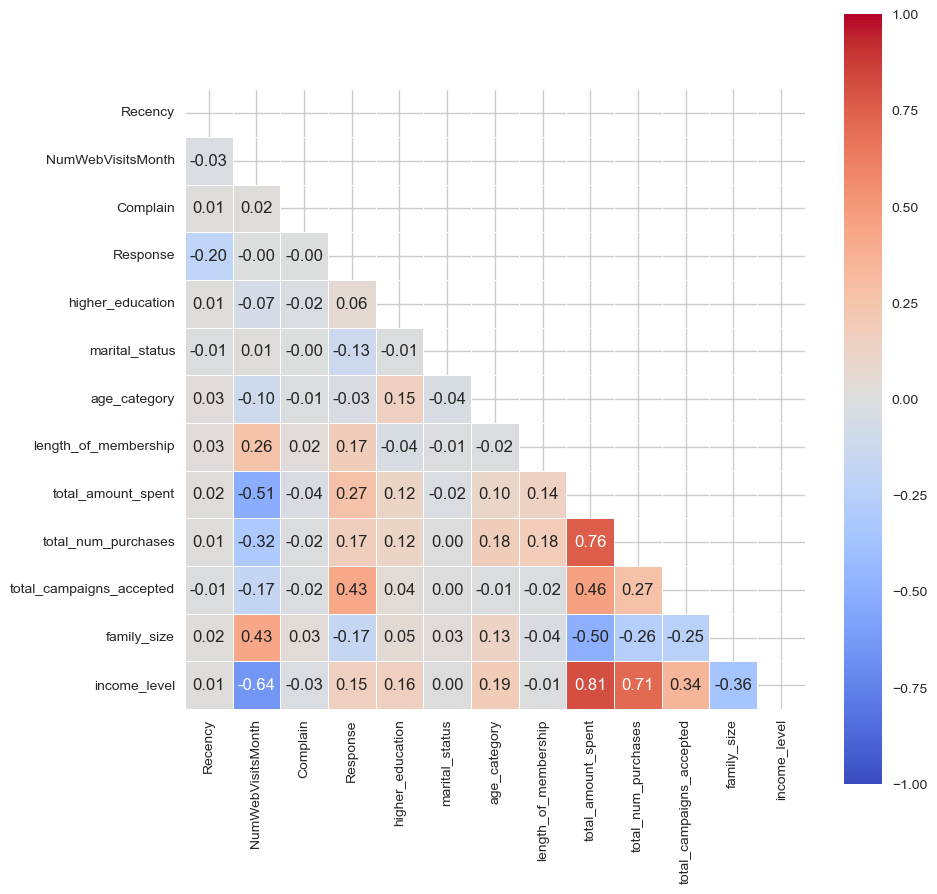

In [46]:
# Calculate correlation matrix
correlation_matrix = X.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set the size of the figure
plt.figure(figsize=(10, 10))

# Plot the heatmap
sns.heatmap(correlation_matrix, cmap='coolwarm', mask=mask,
                square=True,
                linewidths=.5,
                vmin=-1,
                vmax=1,
                annot=True,
                fmt=".2f")
plt.show()

There is no highly correlated variable (>0.90). Just in case total_amount_spent(0.81) was dropped the checked the results. Without dropping, the results were slightly better. So we move on without dropping any column.

In [47]:
# Correlation matrix for 'Response' column after data preparation
correlation_matrix = X.corr()['Response'].sort_values(ascending=False)

print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
Response                    1.000000
total_campaigns_accepted    0.426649
total_amount_spent          0.268858
length_of_membership        0.172527
total_num_purchases         0.165953
income_level                0.150890
higher_education            0.059711
Complain                   -0.002048
NumWebVisitsMonth          -0.002440
age_category               -0.033862
marital_status             -0.130197
family_size                -0.168135
Recency                    -0.200398
Name: Response, dtype: float64


A correlation matrix simply shows the strength and direction of linear relationships between variables. It quantifies how changes in one variable are associated with changes in another variable.
However, correlation does not imply causation. Even if two variables are strongly correlated, it does not necessarily mean that changes in one variable cause changes in the other. 

- **Reference:** *Grus, J. (2015). Data science from scratch: first principles with Python. First edition. Sebastopol, CA, O'Reilly, p. 67.*

So, we will apply different techniques such as RFECV and logit model for feature selection to prevent complex models, by considering correlation matrix as well. 


## **4. MODELING**

In [48]:
# Create the target variable
y = X['Response']

In [49]:
# Make sure target variable is correctly assigned
y.unique()

array([1, 0])

In [50]:
# Drop the target from the training data
X = X.drop(['Response'], axis=1)

We did really good job till here! 

Now, the p-values of features will be checked and the most important features will be included in training. The main objective is to use the minimum possible number of features to create a simple model. Creating a simple model with fewer features helps improve interpretability, reduce overfitting, enhance computational efficiency, increase robustness, and simplify model maintenance.

In [51]:
# Logistic regression analysis 
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.302529
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               Response   No. Observations:                 2215
Model:                          Logit   Df Residuals:                     2203
Method:                           MLE   Df Model:                           11
Date:                Sat, 08 Jun 2024   Pseudo R-squ.:                  0.2853
Time:                        20:50:56   Log-Likelihood:                -670.10
converged:                       True   LL-Null:                       -937.60
Covariance Type:            nonrobust   LLR p-value:                1.091e-107
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Recency                     -0.0291      0.003    -10.544      0.000      -0.035

Logistic Regression analysis can help in feature selection by identifying which features have a significant impact on the outcome. The summary output includes p-values for each coefficient, allowing us to identify features with low p-values (indicating statistical significance) and potentially discard features with high p-values.

Based on logit model, the most important features for predicting the likelihood of response seem to be **`Recency`**, **`NumWebVisitsMonth`**, **`total_amount_spent`**, **`total_campaigns_accepted`**, **`marital_ status`**, **family_size**, and **income_level**. 

- `'Recency'`, `'NumWebVisitsMonth'`, `'total_amount_spent'`, `'total_campaigns_accepted'`, `'marital_status'` all show a statistically significant relationship (p < 0.001) with response.

- `'family_size'` and `'income_level'` also show statistical significance (p = 0.007 and p = 0.002, respectively).

By considering corresponding p-values, we can assess the importance and significance of each feature in predicting the likelihood of response. Features with low p-values are likely to have a stronger impact on the response variable and are therefore more important in our model.

In [52]:
# Drop the features with p-values greater than 0.5
X = X.drop(['Complain', 'higher_education', 'age_category', 'length_of_membership', 'total_num_purchases'], axis=1)

# Confirmation
print(X.columns)

Index(['Recency', 'NumWebVisitsMonth', 'marital_status', 'total_amount_spent',
       'total_campaigns_accepted', 'family_size', 'income_level'],
      dtype='object')


In [53]:
# Split the data into train and test
# By using stratify=y, we ensure that the proportion of each class in the training and test sets reflects the proportion of classes in the original dataset. This helps prevent biases, especially when dealing with imbalanced datasets 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, stratify=y, random_state=random_state) 

In [54]:
# Check shape of the splits to confirm
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1661, 7)
Shape of X_test: (554, 7)
Shape of y_train: (1661,)
Shape of y_test: (554,)


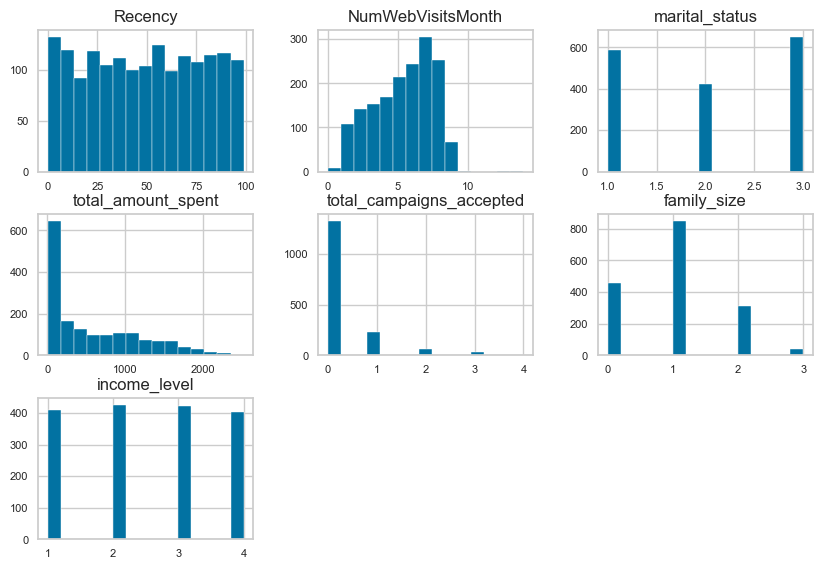

In [55]:
# Check the distributions of the columns before training in case of skewness
numerical=X_train.select_dtypes(include=[np.number]).columns.tolist()
X_train[numerical].hist(bins=15, figsize=(10, 9), layout=(4, 3), xlabelsize=8, ylabelsize=8)
plt.show()

`'total_amount_spent'` column is right skewed. Logarithmic transformation is applied to check whether results are better. But the results are slightly better without transformation with respect to generalization. 

In [56]:
# Apply logarithmic transformation for 'total_amount_spent'
'''X_train['total_amount_spent_log'] = np.log1p(X_train['total_amount_spent'])
X_test['total_amount_spent_log'] = np.log1p(X_test['total_amount_spent'])'''

"X_train['total_amount_spent_log'] = np.log1p(X_train['total_amount_spent'])\nX_test['total_amount_spent_log'] = np.log1p(X_test['total_amount_spent'])"

Counter({0: 1411, 1: 250})
Response
0    0.849488
1    0.150512
Name: proportion, dtype: float64
Imbalance ratio: 5.644


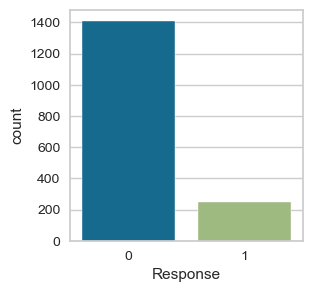

In [57]:
# Display target balance in the training dataset
print(collections.Counter(y_train))
fig, ax = plt.subplots(figsize=(3,3))
sns.countplot(x="Response", data=pd.DataFrame(data={'Response':y_train}), ax=ax)
print(y_train.value_counts(normalize=True))

# Calculate the imbalance ratio
imbalance_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print("Imbalance ratio:", imbalance_ratio)

\begin{align}
ImbalanceRatio = NumberOfSamplesInClass0 / NumberOfSamplesInClass1
\end{align}

**Imbalance ratio** = 1411 / 250 ≈ **5.64**

This means that **class 0 is approximately 5.64 times larger than class 1**, indicating a significant class imbalance in the data at hand.

Different oversampling techniques will be applied and to reduce the bias. And the technique that gives the best generalization, recall and f1 score among the training and test set will be selected.

Counter({1: 1411, 0: 1411})


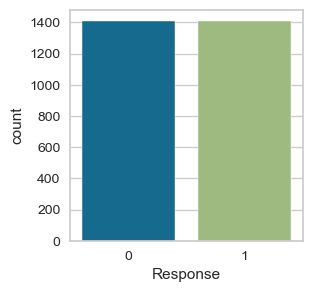

In [58]:
# It is applied SMOTE, BorderlineSMOTE, ADASYN, SMOTE-ENN, Geometric SMOTE, Random Oversampling methods. 
# BorderlineSmote generalize better in train and test sets and gave the highest F1 score among others. 

# Initialize Borderline SMOTE
borderline = BorderlineSMOTE(random_state=random_state)

# Apply Borderline SMOTE to generate new instances (oversampling)
X_train2, y_train2 = borderline.fit_resample(X_train, y_train)

# Display target balance in the training dataset
print(collections.Counter(y_train2))

# Visualize class distribution after applying Borderline SMOTE
fig, ax = plt.subplots(figsize=(3, 3))
sns.countplot(x="Response", data=pd.DataFrame(data={'Response': y_train2}), ax=ax)
plt.show()

In [59]:
# Normalization 
scaler = MinMaxScaler()
X_train2_scaled = scaler.fit_transform(X_train2)
X_test_scaled = scaler.transform(X_test)

# Confirmation
print(X_train2_scaled)
print(X_test_scaled)

[[0.09090909 0.21428571 1.         ... 0.5        0.         1.        ]
 [0.47474747 0.57142857 0.5        ... 0.         0.         0.        ]
 [0.32323232 0.5        1.         ... 0.         0.33333333 0.        ]
 ...
 [0.17171717 0.57142857 0.         ... 0.         0.         0.33333333]
 [0.1010101  0.57142857 0.         ... 0.         0.         0.33333333]
 [0.60606061 0.14285714 0.         ... 0.25       0.         1.        ]]
[[0.42424242 0.14285714 0.         ... 0.         0.         1.        ]
 [0.28282828 0.28571429 0.         ... 0.         0.         1.        ]
 [0.90909091 0.42857143 0.         ... 0.         0.33333333 0.        ]
 ...
 [0.48484848 0.35714286 1.         ... 0.         0.         0.33333333]
 [0.02020202 0.35714286 0.5        ... 0.         0.         1.        ]
 [0.81818182 0.35714286 1.         ... 0.         0.33333333 0.66666667]]


Normalization is a crucial preprocessing step for logistic regression that helps improve convergence, equalize feature influence, facilitate regularization, maintain interpretability, and enhance the model's robustness to outliers and differences in feature scales. Since there is no one-size-fits-all, we applied normalization after oversampling which gives slightly better results.

### **GridSearchCV - Hyperparameter Tuning** 

In [60]:
# Define hyperparameters to tune
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l2'], 'solver': ['liblinear']}

# Initialize logistic regression model
lr = LogisticRegression(max_iter=1000)

# Perform grid search with 10-fold cross-validation and scoring based on F1 score
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=10, scoring='f1_weighted')
grid_search.fit(X_train2_scaled, y_train2)

# Get best hyperparameters
best_params = grid_search.best_params_
best_params

{'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}

In [61]:
# Initiate the model with best parameters 
lr = LogisticRegression(**best_params, random_state=random_state)

### **Recursive Feature Elimination with Cross Validation**

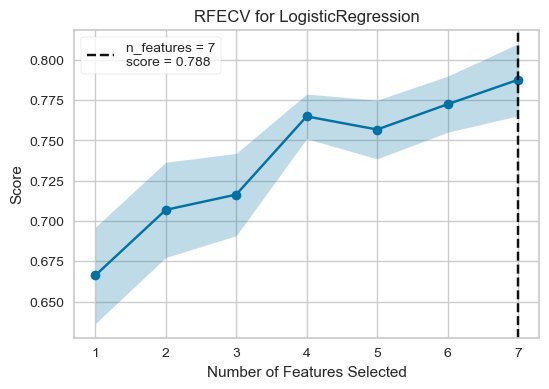

<Axes: title={'center': 'RFECV for LogisticRegression'}, xlabel='Number of Features Selected', ylabel='Score'>

In [62]:
plt.figure(figsize=(6,4))
# Recursive Feature Elimination with Cross Validation
vis = RFECV(lr, cv=10, scoring='f1_weighted')
vis.fit(X_train2_scaled, y_train2)
vis.show()

RFECV is suggested to include all the features. 

### **Learning Curve**

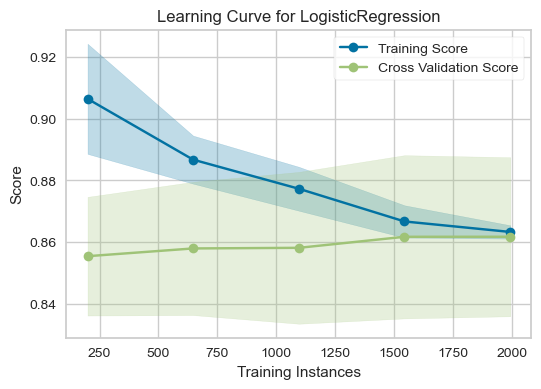

In [86]:
plt.figure(figsize=(6,4))
# Plot the learning curve
sizes = np.linspace(0.1, 1.0, 5)
visualizer = LearningCurve(estimator=lr, cv=10, scoring='f1_weighted', train_sizes=sizes, n_jobs=4, random_state=random_state)
visualizer.fit(X, y)
visualizer.show()

# Display the plot
plt.show()

### **Cross Validation** 

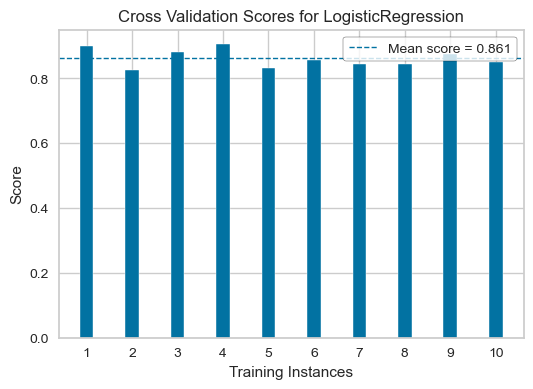

<Axes: title={'center': 'Cross Validation Scores for LogisticRegression'}, xlabel='Training Instances', ylabel='Score'>

<Figure size 800x550 with 0 Axes>

In [79]:
plt.figure(figsize=(6,4))
# Visualize cross validation scores
visualizer = CVScores(lr, cv=10, scoring='f1_weighted')

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

### **Discrimination Threshold**

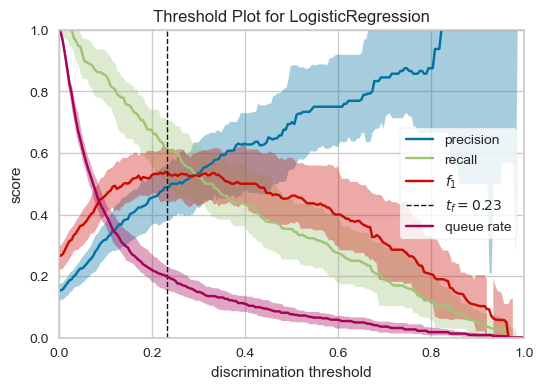

<Axes: title={'center': 'Threshold Plot for LogisticRegression'}, xlabel='discrimination threshold', ylabel='score'>

In [65]:
plt.figure(figsize=(6,4))
# Instantiate the DiscriminationThreshold visualizer with the model
visualizer = DiscriminationThreshold(lr, random_state=random_state)

# Fit the data to the visualizer
visualizer.fit(X, y)

# Visualize the discrimination threshold
visualizer.show()

In [66]:
# Train the model
lr.fit(X_train2_scaled, y_train2)

LogisticRegression(C=100, random_state=2024, solver='liblinear')

In [67]:
# It is tried different thresholds to balance the precision and recall and have the highest f1 score. Default threshold 0.5 has the highest f1 score.  
threshold = 0.50  # [[0.1, 0.23, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]]

# Predict probabilities for train and test sets
y_prob_train = lr.predict_proba(X_train2_scaled)[:, 1]
y_prob_test = lr.predict_proba(X_test_scaled)[:, 1]

# Apply threshold to convert probabilities to binary predictions
y_pred_train = (y_prob_train >= threshold).astype(int)
y_pred_test = (y_prob_test >= threshold).astype(int)

In [68]:
# Show performance results
resultsDF = performanceMetricsDF(metrics, y_train2, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,Accuracy,0.792346,0.776173
1,Precision,0.790698,0.381503
2,Recall,0.795181,0.795181
3,F1-score,0.792933,0.515625
4,Specificity,0.789511,0.772824
5,G-Mean,0.792341,0.783923


### **ROC-AUC**

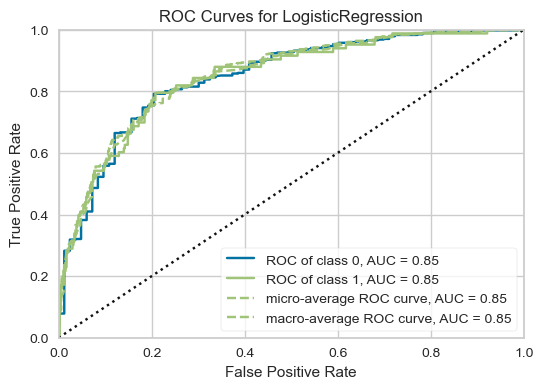

<Axes: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [69]:
plt.figure(figsize=(6,4))
# ROC curve
visualizer = ROCAUC(lr, classes=['0','1'])
visualizer.fit(X_train2_scaled, y_train2)
visualizer.score(X_test_scaled, y_test)
visualizer.show()

- *"[…] **the visual interpretability of ROC plots in the context of imbalanced datasets can be deceptive with respect to conclusions about the reliability of classification performance, owing to an intuitive but wrong interpretation of specificity. [Precision-recall curve] plots, on the other hand, can provide the viewer with an accurate prediction of future classification performance due to the fact that they evaluate the fraction of true positives among positive predictions.**"*

Reference: Saito, T., & Rehmsmeier, M. (2015). The precision-recall plot is more informative than the ROC plot when evaluating binary classifiers on imbalanced datasets. PloS one, 10(3), e0118432. https://doi.org/10.1371/journal.pone.0118432

### **Precision-Recall Curve**

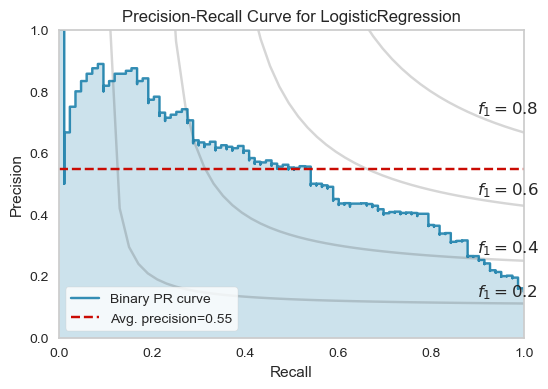

<Axes: title={'center': 'Precision-Recall Curve for LogisticRegression'}, xlabel='Recall', ylabel='Precision'>

In [70]:
plt.figure(figsize=(6,4))
# Precison-Recall curve
visualizer = PrecisionRecallCurve(lr, classes=['0','1'], ap_score=True, iso_f1_curves=True)
visualizer.fit(X_train2_scaled, y_train2)
visualizer.score(X_test_scaled, y_test)
visualizer.show()

### **Confusion Matrix**

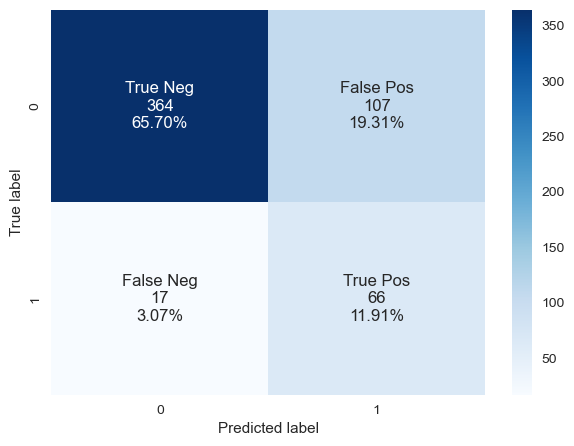

In [71]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',
                      figsize=(7,5))

### **Class Prediction Error** 

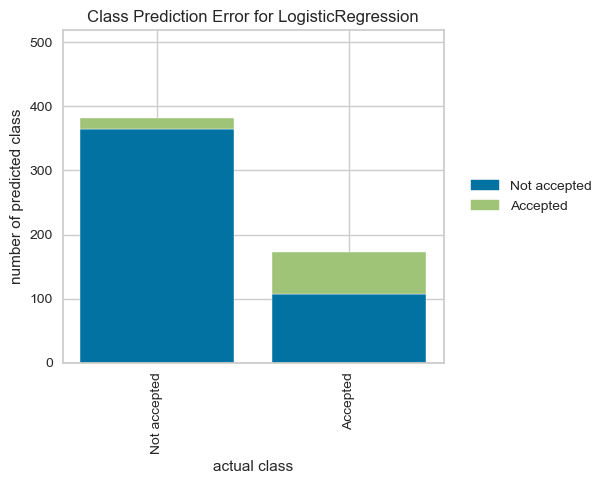

<Axes: title={'center': 'Class Prediction Error for LogisticRegression'}, xlabel='actual class', ylabel='number of predicted class'>

In [72]:
classes = ['Not accepted','Accepted']
plt.figure(figsize=(7,5))
# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(lr, classes=classes)

# Fit the training data to the visualizer
visualizer.fit(X_train2_scaled, y_train2)

# Evaluate the model on the test data
visualizer.score(X_test_scaled, y_test)

# Draw visualization
visualizer.show()

In [73]:
# Show features coefficients
abs_coef = np.concatenate(np.abs(lr.coef_))
sorted_index = np.argsort(abs_coef)[::-1] # sort indices
feature_coef = sorted_index[:10]
feature_coefDF = pd.DataFrame(data={'feature': list(X_train.columns[feature_coef]), 'coef': abs_coef[feature_coef]})
feature_coefDF

,feature,coef
0,total_amount_spent,4.608256
1,total_campaigns_accepted,3.859582
2,NumWebVisitsMonth,3.167518
3,Recency,3.036887
4,family_size,2.903364
5,income_level,1.880346
6,marital_status,1.698048


In [74]:
# Save the best model
file = open("model.pickle", "wb")
pickle.dump(lr, file)
file.close()

## **5. EVALUATION**

Based on the evaluation metrics for both training and test sets, it appears that the best-performing model is the one with the following characteristics:

### **Model**: Logistic Regression
#### **Performance Metrics**
*Train and Test results*:
- **Accucary:** 
        <p>*The model's accuracy on the training set is 79.2%, while on the test set, it is slightly lower at 77.6%. This indicates that the model performs fairly consistently across both datasets, with a slight drop in the test set, which is expected.*
- **Precision:** 
        <p>*Precision drops significantly from 79.1% on the training set to 38.2% on the test set. This suggests that the model is much better at correctly identifying positive instances on the training set than on the test set.*
- **Recall:**
        <p>*Recall remains constant at 79.5% for both the training and test sets. This consistency indicates that the model is equally effective at capturing true positive instances across both sets.*
- **F1-score:**
        <p>*The F1-score, which balances precision and recall, drops from 79.3% on the training set to 51.6% on the test set. This significant decrease aligns with the drop in precision, highlighting issues with the model's performance in identifying true positives accurately on the test set. This decrease in F1-score on the test set indicates a trade-off between precision and recall.*
- **Specificity:**
        <p>*Specificity, or the ability to correctly identify negative instances, is 79.0% on the training set and 77.3% on the test set. This minor decrease indicates the model's performance in recognizing negatives is relatively stable across both sets.*     
- **G-mean:**
        <p>*The geometric mean (G-Mean), which combines the true positive rate (recall) and the true negative rate (specificity), is 79.2% on the training set and 78.4% on the test set. This shows a balanced performance in identifying both positives and negatives, with only a slight reduction on the test set.*


#### **Feature Importance**
*Top 5 Features*:
- total_amount_spent
- total_campaigns_accepted
- NumWebVisitsMonth
- Recency
- family_size

*Significant Features*:
income_level and marital_status also show notable impacts on the target variable.

#### **Learning Curve**

The Logistic regression model's performance on both training and cross-validation data can be seen in the learning curve plot based on the weighted f1 score. The model performs better on the training set of data at first, but after an unusual start, the cross-validation scores improve slightly by following the same pattern with train scores. The two curves eventually converge at a specific point, signifying consistent performance on unseen data. This convergence shows that the model generalizes well without significant underfitting or overfitting. 

#### **ROC-AUC**
ROC AUC of 0.85 for both class 0 and class 1 indicates that the model has good discriminative power for both classes. The micro-average ROC AUC, if also around 0.85, confirms that the model performs well on average across all classes. This is the highest score among the models.


#### **Precision-Recall Curve**
This is a single-number summary of the precision-recall curve, calculated as the area under the PR curve (AUPRC). An AP of 0.55 means that, on average, the precision across different recall levels is 0.55. An average precision of 0.55 indicates a model with moderate performance in balancing precision and recall. A higher AP score indicates a better balance between precision and recall across all thresholds. AP with 0.55 is the best score among the other models. 


#### **Confusion Matrix**
With logistic regression model, we achieved the highest true positive rates(%11.9) and true negative rates(%65.70). Since the Ms. Sarah concerns about TPR(recall) than the other metrics, this model provides better results with respect to business needs. 

#### **Overall Assessment**
Tree-based models didn't generalize well in the data with the high difference between train and test scores. The Logistic Regression model demonstrates strong predictive performance with relatively low difference between train and test results, indicating a good generalization. It is achived to have best results possible with the most simplest model and less features. Only 7 features were created from 28 features. The feature importance analysis reveals several key factors influencing the target variable, including total_amount_spent, total_campaign_accepted, and Recency. 

#### **Understanding the Trade-Off**

*High Recall, Lower Precision:* (BUSINESS NEED)
- **Scenario**: You send the campaign to a broad audience to capture nearly all potential responders.
- **Pros**: Maximum reach, ensuring most potential customers are contacted.
- **Cons**: Higher marketing costs, increased likelihood of annoying uninterested customers, lower overall campaign efficiency.

*High Precision, Lower Recall:*
- **Scenario**: You send the campaign to a targeted, highly likely-to-respond audience.
- **Pros**: Cost-efficient, higher customer satisfaction due to relevant offers, better use of marketing resources.
- **Cons**: Misses some potential responders, possibly reducing the total number of responses.